***
#### BF-DnCNN
***

In [17]:
from torchsummary import summary
import torch
from torch.nn.modules.loss import _Loss
import torch.nn.init as init
import torch.nn as nn
from IPython.display import Image
from models import * 
from utils.denoising_utils import *
from lrw_data_loader import LRW
dtype = torch.cuda.FloatTensor
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
class DnCNN(nn.Module):
    def __init__(self, depth=17, bias = True,
                 n_channels=64, image_channels=1, 
                 use_bnorm=True, kernel_size=3):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        layers = []

        layers.append(nn.Conv2d(in_channels=image_channels, 
                                out_channels=n_channels, 
                                kernel_size=kernel_size, 
                                padding=padding, bias=bias))
        layers.append(nn.ReLU(inplace=True))
        
        for _ in range(depth-2):
            layers.append(nn.Conv2d(in_channels=n_channels, 
                                    out_channels=n_channels, 
                                    kernel_size=kernel_size, 
                                    padding=padding, bias=bias))
            layers.append(nn.BatchNorm2d(n_channels, eps=0.0001, momentum = 0.95))
            layers.append(nn.ReLU(inplace=True))
        
        layers.append(nn.Conv2d(in_channels=n_channels, 
                                out_channels=image_channels, 
                                kernel_size=kernel_size, 
                                padding=padding, bias=bias))
        self.dncnn = nn.Sequential(*layers)
        self._initialize_weights()

    def forward(self, x):
        y = x
        out = self.dncnn(x)
        return y-out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.orthogonal_(m.weight)
                print('init weight')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)


class sum_squared_error(_Loss):  # PyTorch 0.4.1
    """
    Definition: sum_squared_error = 1/2 * nn.MSELoss(reduction = 'sum')
    The backward is defined as: input-target
    """
    def __init__(self, size_average=None, reduce=None, reduction='sum'):
        super(sum_squared_error, self).__init__(size_average, reduce, reduction)

    def forward(self, input, target):
        # return torch.sum(torch.pow(input-target,2), (0,1,2,3)).div_(2)
        return torch.nn.functional.mse_loss(input, target, size_average=None, reduce=None, reduction='sum').div_(2)


In [14]:
v2v = '../vid2vid_out/fake_B_keypoints_00015.jpg'
unsmoothed = '../unsmoothed/0014.png'
orig = '../original_frames/frame15.jpg'
img_noisy = get_image(unsmoothed)
img_v2v = get_image(v2v)
img_original = get_image(orig)


In [4]:
from IPython.display import Image

# Image(v2v)

In [5]:
width, height = img_original[0].size   # Get dimensions

left = 925 - (300 / 2)# (width - new_width) / 2
top = 435 - (300 / 2)# (height - new_height) / 3
right = 925 + (300 / 2)# (width + new_width) / 2
bottom = 435 + (300 / 2)# (height + new_height) / 2.2 


base_mouth_center_y = 435
base_mouth_center_x = 925
base_mouth_length = 105

In [6]:
# img_noisy[0].crop((left, top, right, bottom))
# x = torch.ones(img_noisy[1].shape)
# x.normal_() 
# x

In [10]:
to_tensor(img_noisy[0].crop((left, top, right, bottom))).shape


torch.Size([3, 300, 300])

In [38]:
model = DnCNN(bias = True,
             image_channels=3).type(dtype).to(device)
criterion = nn.MSELoss()
learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight


In [39]:
%%time
from torchvision import transforms
num_epochs = 2000
to_tensor = transforms.ToTensor()
do = nn.Dropout()  # comment out for standard AE
img_n = img_noisy[0].crop((left, top, right, bottom))
width, height = img_n.size
img_unsmoothed = to_tensor(img_n).reshape(-1, 3, width, height).to(device)

for epoch in range(num_epochs):
    
    noise = torch.ones(img_unsmoothed.shape)
    noise = do(noise.uniform_()) 
    noise = noise.to(device)
    img_bad = (img_unsmoothed * noise).to(device)# (img * noise).to(device)  # comment out for standard AE
    # ===================forward=====================
    output = model(img_bad)  # feed <img> (for std AE) or <img_bad> (for denoising AE)
    loss = criterion(output, img_unsmoothed.data)
    # ===================backward====================
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # ===================log========================
    if epoch % 250 == 0:
        print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
        

epoch [1/2000], loss:0.5052
epoch [251/2000], loss:0.0139
epoch [501/2000], loss:0.0046
epoch [751/2000], loss:0.0031
epoch [1001/2000], loss:0.0027
epoch [1251/2000], loss:0.0021
epoch [1501/2000], loss:0.0019
epoch [1751/2000], loss:0.0021
CPU times: user 2min 23s, sys: 16.6 s, total: 2min 40s
Wall time: 2min 29s


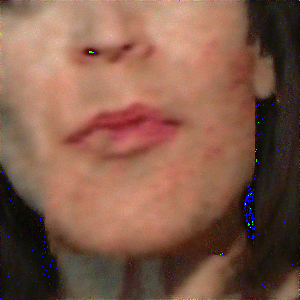

In [37]:
to_image = transforms.ToPILImage()
to_image(output.reshape(3, width, height).cpu())

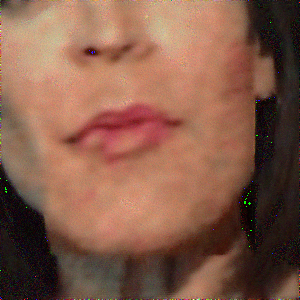

In [40]:
to_image = transforms.ToPILImage()
to_image(output.reshape(3, width, height).cpu())